In [439]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Tuple
from scipy.ndimage import gaussian_filter, uniform_filter
from scipy.interpolate import interp2d

In [440]:
sigma = 20

Lecture du fichier Matlab

In [441]:
def read_mat_file(file_path):
    data = scipy.io.loadmat(file_path)
    return data

def split_3d_array(array_3d):
    # Ensure the array has the expected shape
    if array_3d.shape[2] != 5:
        raise ValueError("The loaded array does not have the expected third dimension size of 5.")
    
    # Extract the 2D arrays
    arrays = [array_3d[:, :, i].astype(float) for i in range(5)]
    return arrays

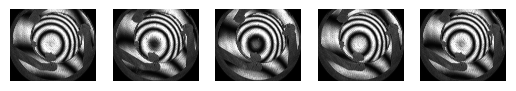

In [442]:
data = read_mat_file("/Users/dorianmendes/Desktop/SupOptique/1A/Stage & Admisseur/Stage LEnsE/camera-gui-repository/applis/Zygo-labwork/_data/imgs2.mat")
images = data['Imgs']
images = split_3d_array(images)

for i, img in enumerate(images):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

Application du mask

In [443]:
def selection_surface_utile(mask):
    a, b = mask.shape

    xmin = 0
    while xmin < a and np.sum(mask[xmin, :]) == 0:
        xmin += 1

    xmax = a - 1
    while xmax > 0 and np.sum(mask[xmax, :]) == 0:
        xmax -= 1

    ymin = 0
    while ymin < b and np.sum(mask[:, ymin]) == 0:
        ymin += 1

    ymax = b - 1
    while ymax > 0 and np.sum(mask[:, ymax]) == 0:
        ymax -= 1

    mask_select = mask[xmin:xmax+1, ymin:ymax+1]

    return mask_select, xmin, xmax, ymin, ymax

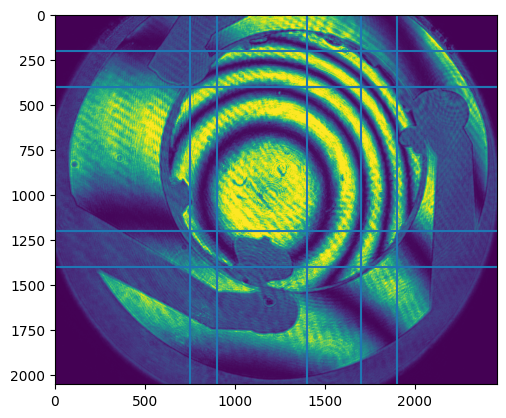

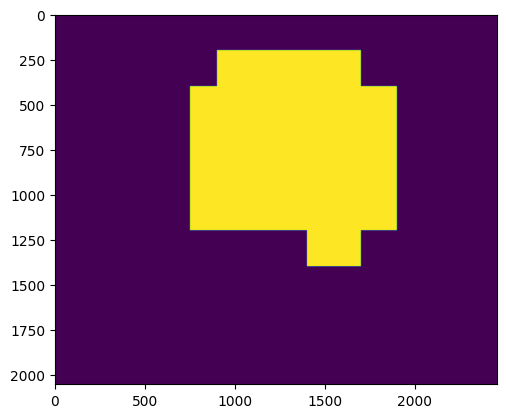

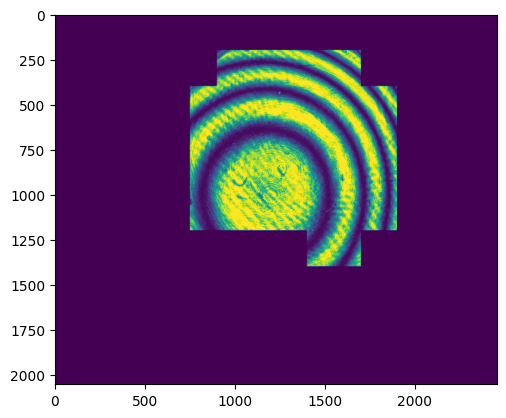

In [444]:
plt.imshow(images[0])
plt.axhline(400); plt.axhline(1200)
plt.axvline(750); plt.axvline(1900)

plt.axhline(200); plt.axhline(400)
plt.axvline(900); plt.axvline(1700)

plt.axhline(1200); plt.axhline(1400)
plt.axvline(1400); plt.axvline(1700)
plt.show()

mask = np.zeros_like(images[0])
mask[400:1200, 750:1900] = 1
mask[200:400, 900:1700] = 1
mask[1200:1400, 1400:1700] = 1
plt.imshow(mask)
plt.show()

plt.figure()
plt.imshow(images[0]*mask)

In [445]:
for image in images:
    image[mask==0] = np.nan
    image = image[400:1200, 750:1900]

Filtrage

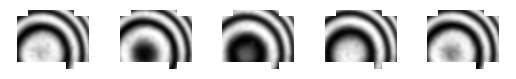

In [446]:
images_filtrees = list(map(lambda x:gaussian_filter(x, sigma), images))

for i, img in enumerate(images_filtrees):
    plt.subplot(1,5,i+1)
    plt.imshow(img[400:1200, 750:1900], cmap='gray')
    plt.axis('off')

In [447]:
def hariharan_algorithm(intensity_1: np.ndarray, intensity_2: np.ndarray, intensity_3: np.ndarray, intensity_4: np.ndarray, intensity_5: np.ndarray) -> np.ndarray:
    num = 2 * (intensity_4 - intensity_2)
    denum = 2 * intensity_3 - intensity_5 - intensity_1
    return np.arctan2(num, denum)

In [448]:
phase = hariharan_algorithm(*images_filtrees)

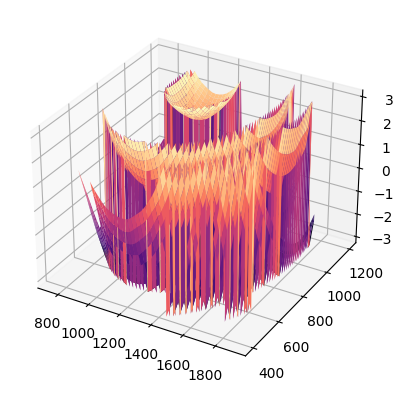

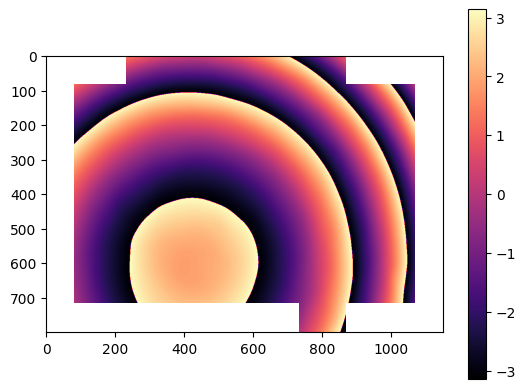

In [449]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(phase.shape[1]); y = np.arange(phase.shape[0])
x, y = np.meshgrid(x, y)

# Tracé de la surface
ax.plot_surface(x[400:1200, 750:1900], y[400:1200, 750:1900], phase[400:1200, 750:1900], cmap='magma')

plt.figure()
plt.imshow(phase[400:1200, 750:1900], cmap='magma')
plt.colorbar()


In [450]:
def unwrap1(xe: np.ndarray, sautLimite: float = np.pi, dim: Optional[int] = None) -> np.ndarray:
    P = 2 * sautLimite
    sxe = np.shape(xe)
    if dim is None:
        dim = 0
        xe = np.squeeze(xe)
    else:
        dim -= 1
        xe = np.moveaxis(xe, dim, 0)

    yd = xe.copy()
    for j in range(sxe[dim]):
        y = yd[j]
        k = ~np.isnan(y)
        ysn = y[k]
        dysn = np.diff(ysn, prepend=0)
        saut = -np.round(dysn / P) * P
        yd[j, k] = ysn + np.cumsum(saut)

    if dim != 0:
        yd = np.moveaxis(yd, 0, dim)
    return yd

def unwrap2D(Ph: np.ndarray) -> np.ndarray:
    PhDc = unwrap1(Ph)
    PhDl = unwrap1(Ph.T).T

    both = (~np.isnan(PhDc)) & (~np.isnan(PhDl))
    offsetBrut = np.mean(PhDc[both] - PhDl[both])
    offset = 2 * np.pi * round(offsetBrut / (2 * np.pi))
    ecarto = np.abs(offset - offsetBrut)

    pb = np.abs(PhDc - PhDl - offset) > np.pi / 10000
    plt.imshow(pb)

    Voffset = PhDc[both & (~pb)] - PhDl[both & (~pb)]
    offsetBrut = np.mean(Voffset)
    offset = 2 * np.pi * round(offsetBrut / (2 * np.pi))
    ecarttype = np.std(Voffset)

    NbPPb = np.sum(pb)
    NbBoth = np.sum(both)
    rapp = NbPPb / NbBoth

    info = [ecarttype, ecarto, rapp]

    tauxMaxPtsDiff = 0.05

    if rapp > tauxMaxPtsDiff or ecarttype > np.pi / 10000:
        Pb = True
        PhD = PhDc.copy()
        PhD[~both] = np.nan
        PhD[pb] = np.nan
    else:
        Pb = False
        PhD = PhDc.copy()
        PhD[~both] = PhDl[~both] + offset

        k, m = np.where(pb)
        for i, j in zip(k, m):
            if i in [0, PhD.shape[0]-1] or j in [0, PhD.shape[1]-1]:
                PhD[i, j] = np.nan
            else:
                errc = np.diff(PhDc[i, j-1:j+2])
                errl = np.diff(PhDl[i-1:i+2, j])
                Pbc = np.any(np.abs(errc) > np.pi)
                Pbl = np.any(np.abs(errl) > np.pi)

                if Pbc and Pbl:
                    PhD[i, j] = np.nan
                elif Pbc:
                    PhD[i, j] = PhDl[i, j] + offset
                elif Pbl:
                    pass
    return PhD

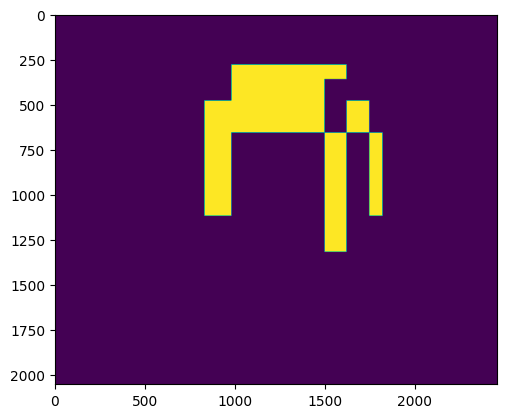

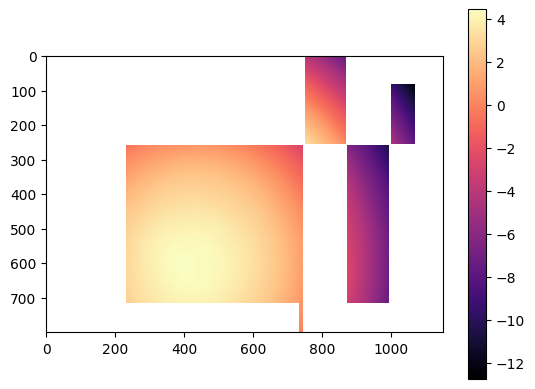

In [451]:
unwrapped = -unwrap2D(phase)[400:1200, 750:1900]

plt.figure()
plt.imshow(unwrapped, cmap='magma')
plt.colorbar()

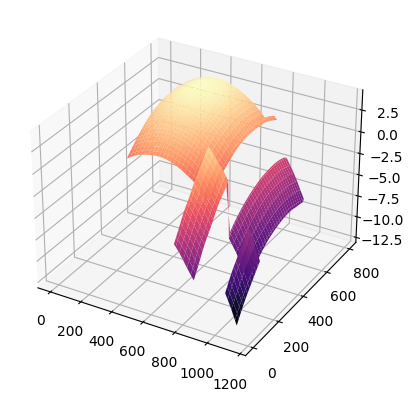

In [452]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(unwrapped.shape[1]); y = np.arange(unwrapped.shape[0])
x, y = np.meshgrid(x, y)

# Tracé de la surface
ax.plot_surface(x, y, unwrapped, cmap='magma')

In [453]:
def suppression_bord(phi, p):
    a, b = phi.shape

    phi2 = np.full((a + 20, b + 20), np.nan)
    phi2[10:a + 10, 10:b + 10] = phi

    MatrixNaN = 100 * np.isnan(phi2)

    # Utilisation du filtre moyen (équivalent à fspecial('average', p) en MATLAB)
    H = np.ones((p, p)) / (p * p)
    maskinverse = uniform_filter(MatrixNaN, size=p)

    maskinverse[maskinverse != 0] = 1

    for i in range(a + 20):
        for j in range(b + 20):
            if maskinverse[i, j] != 0:
                phi2[i, j] = np.nan

    MatrixNotNaN = ~np.isnan(phi2)

    mask, xmin, xmax, ymin, ymax = selection_surface_utile(MatrixNotNaN)

    phi2 = phi2[xmin:xmax, ymin:ymax]

    return phi2

In [454]:
phi = suppression_bord(unwrapped, 3)
phi = phi - np.nanmean(phi)

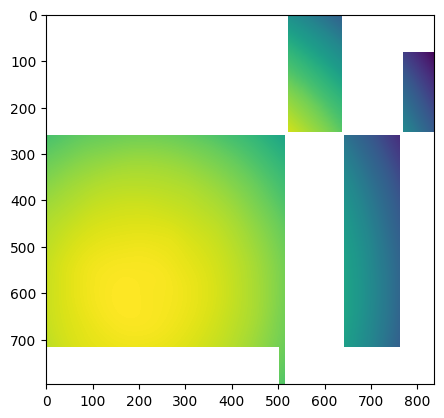

In [455]:
plt.imshow(phi)

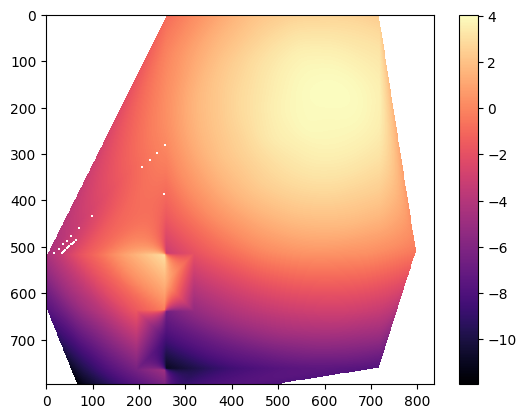

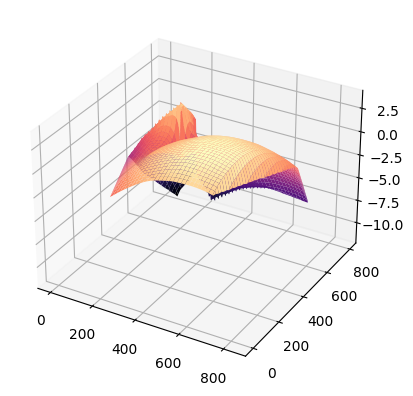

In [456]:
not_nan_indices = np.where(~np.isnan(phi))

# Récupérez les valeurs non-nan et leurs coordonnées
values = phi[not_nan_indices]
x = not_nan_indices[0]
y = not_nan_indices[1]

# Générer une grille de points pour l'interpolation
x_grid, y_grid = np.meshgrid(np.arange(phi.shape[1]), np.arange(phi.shape[0]))

# Interpolez les valeurs manquantes
interpolated_values = griddata((x, y), values, (x_grid, y_grid), method='linear')

# Affichage de l'interpolation
plt.imshow(interpolated_values, cmap='magma')
plt.colorbar()
plt.show()

# Affichage en 3D de l'interpolation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(interpolated_values.shape[1])
y = np.arange(interpolated_values.shape[0])
x, y = np.meshgrid(x, y)

# Tracé de la surface
ax.plot_surface(x, y, interpolated_values, cmap='magma')

plt.show()

***
***

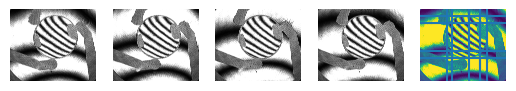

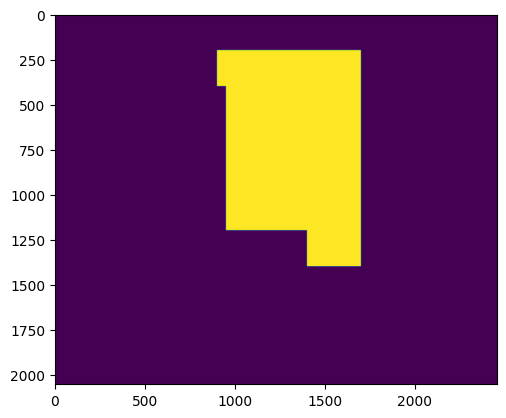

/var/folders/gt/k25rhkmx0hn8khpk528r227r0000gn/T/ipykernel_75722/2297978287.py:73: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,5,i+1)


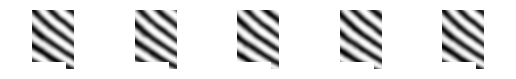

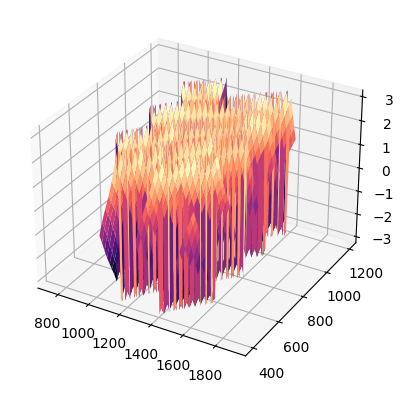

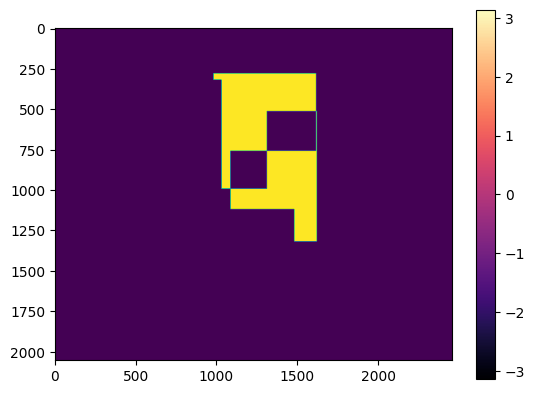

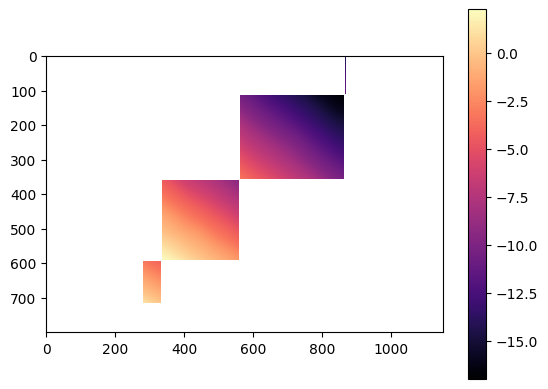

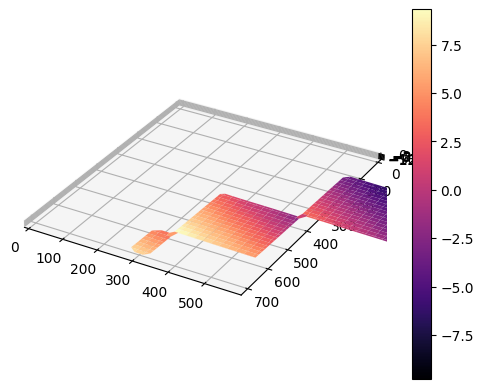

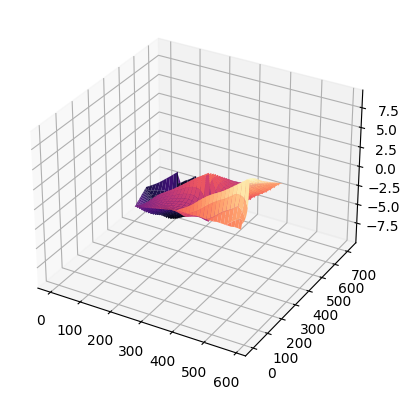

In [460]:
sigma = 20

def read_mat_file(file_path):
    data = scipy.io.loadmat(file_path)
    return data

def split_3d_array(array_3d):
    # Ensure the array has the expected shape
    if array_3d.shape[2] != 5:
        raise ValueError("The loaded array does not have the expected third dimension size of 5.")
    
    # Extract the 2D arrays
    arrays = [array_3d[:, :, i].astype(float) for i in range(5)]
    return arrays
data = read_mat_file("/Users/dorianmendes/Desktop/SupOptique/1A/Stage & Admisseur/Stage LEnsE/camera-gui-repository/applis/Zygo-labwork/_data/imgs1.mat")
images = data['Imgs']
images = split_3d_array(images)

for i, img in enumerate(images):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

def selection_surface_utile(mask):
    a, b = mask.shape

    xmin = 0
    while xmin < a and np.sum(mask[xmin, :]) == 0:
        xmin += 1

    xmax = a - 1
    while xmax > 0 and np.sum(mask[xmax, :]) == 0:
        xmax -= 1

    ymin = 0
    while ymin < b and np.sum(mask[:, ymin]) == 0:
        ymin += 1

    ymax = b - 1
    while ymax > 0 and np.sum(mask[:, ymax]) == 0:
        ymax -= 1

    mask_select = mask[xmin:xmax+1, ymin:ymax+1]

    return mask_select, xmin, xmax, ymin, ymax
plt.imshow(images[0])
plt.axhline(400); plt.axhline(1200)
plt.axvline(750); plt.axvline(1900)

plt.axhline(200); plt.axhline(400)
plt.axvline(900); plt.axvline(1700)

plt.axhline(1200); plt.axhline(1400)
plt.axvline(1400); plt.axvline(1700)
plt.show()

mask = np.zeros_like(images[0])
mask[400:1200, 950:1700] = 1
mask[200:400, 900:1700] = 1
mask[1200:1400, 1400:1700] = 1
plt.imshow(mask)
plt.show()

plt.figure()
plt.imshow(images[0]*mask)
for image in images:
    image[mask==0] = np.nan
    image = image[400:1200, 750:1900]

images_filtrees = list(map(lambda x:gaussian_filter(x, sigma), images))

for i, img in enumerate(images_filtrees):
    plt.subplot(1,5,i+1)
    plt.imshow(img[400:1200, 750:1900], cmap='gray')
    plt.axis('off')
def hariharan_algorithm(intensity_1: np.ndarray, intensity_2: np.ndarray, intensity_3: np.ndarray, intensity_4: np.ndarray, intensity_5: np.ndarray) -> np.ndarray:
    num = 2 * (intensity_4 - intensity_2)
    denum = 2 * intensity_3 - intensity_5 - intensity_1
    return np.arctan2(num, denum)
phase = hariharan_algorithm(*images_filtrees)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(phase.shape[1]); y = np.arange(phase.shape[0])
x, y = np.meshgrid(x, y)

# Tracé de la surface
ax.plot_surface(x[400:1200, 750:1900], y[400:1200, 750:1900], phase[400:1200, 750:1900], cmap='magma')

plt.figure()
plt.imshow(phase[400:1200, 750:1900], cmap='magma')
plt.colorbar()

def unwrap1(xe: np.ndarray, sautLimite: float = np.pi, dim: Optional[int] = None) -> np.ndarray:
    P = 2 * sautLimite
    sxe = np.shape(xe)
    if dim is None:
        dim = 0
        xe = np.squeeze(xe)
    else:
        dim -= 1
        xe = np.moveaxis(xe, dim, 0)

    yd = xe.copy()
    for j in range(sxe[dim]):
        y = yd[j]
        k = ~np.isnan(y)
        ysn = y[k]
        dysn = np.diff(ysn, prepend=0)
        saut = -np.round(dysn / P) * P
        yd[j, k] = ysn + np.cumsum(saut)

    if dim != 0:
        yd = np.moveaxis(yd, 0, dim)
    return yd

def unwrap2D(Ph: np.ndarray) -> np.ndarray:
    PhDc = unwrap1(Ph)
    PhDl = unwrap1(Ph.T).T

    both = (~np.isnan(PhDc)) & (~np.isnan(PhDl))
    offsetBrut = np.mean(PhDc[both] - PhDl[both])
    offset = 2 * np.pi * round(offsetBrut / (2 * np.pi))
    ecarto = np.abs(offset - offsetBrut)

    pb = np.abs(PhDc - PhDl - offset) > np.pi / 10000
    plt.imshow(pb)

    Voffset = PhDc[both & (~pb)] - PhDl[both & (~pb)]
    offsetBrut = np.mean(Voffset)
    offset = 2 * np.pi * round(offsetBrut / (2 * np.pi))
    ecarttype = np.std(Voffset)

    NbPPb = np.sum(pb)
    NbBoth = np.sum(both)
    rapp = NbPPb / NbBoth

    info = [ecarttype, ecarto, rapp]

    tauxMaxPtsDiff = 0.05

    if rapp > tauxMaxPtsDiff or ecarttype > np.pi / 10000:
        Pb = True
        PhD = PhDc.copy()
        PhD[~both] = np.nan
        PhD[pb] = np.nan
    else:
        Pb = False
        PhD = PhDc.copy()
        PhD[~both] = PhDl[~both] + offset

        k, m = np.where(pb)
        for i, j in zip(k, m):
            if i in [0, PhD.shape[0]-1] or j in [0, PhD.shape[1]-1]:
                PhD[i, j] = np.nan
            else:
                errc = np.diff(PhDc[i, j-1:j+2])
                errl = np.diff(PhDl[i-1:i+2, j])
                Pbc = np.any(np.abs(errc) > np.pi)
                Pbl = np.any(np.abs(errl) > np.pi)

                if Pbc and Pbl:
                    PhD[i, j] = np.nan
                elif Pbc:
                    PhD[i, j] = PhDl[i, j] + offset
                elif Pbl:
                    pass
    return PhD
unwrapped = -unwrap2D(phase)[400:1200, 750:1900]

plt.figure()
plt.imshow(unwrapped, cmap='magma')
plt.colorbar()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(unwrapped.shape[1]); y = np.arange(unwrapped.shape[0])
x, y = np.meshgrid(x, y)

# Tracé de la surface
ax.plot_surface(x, y, unwrapped, cmap='magma')
def suppression_bord(phi, p):
    a, b = phi.shape

    phi2 = np.full((a + 20, b + 20), np.nan)
    phi2[10:a + 10, 10:b + 10] = phi

    MatrixNaN = 100 * np.isnan(phi2)

    # Utilisation du filtre moyen (équivalent à fspecial('average', p) en MATLAB)
    H = np.ones((p, p)) / (p * p)
    maskinverse = uniform_filter(MatrixNaN, size=p)

    maskinverse[maskinverse != 0] = 1

    for i in range(a + 20):
        for j in range(b + 20):
            if maskinverse[i, j] != 0:
                phi2[i, j] = np.nan

    MatrixNotNaN = ~np.isnan(phi2)

    mask, xmin, xmax, ymin, ymax = selection_surface_utile(MatrixNotNaN)

    phi2 = phi2[xmin:xmax, ymin:ymax]

    return phi2
phi = suppression_bord(unwrapped, 3)
phi = phi - np.nanmean(phi)
plt.imshow(phi)
not_nan_indices = np.where(~np.isnan(phi))

# Récupérez les valeurs non-nan et leurs coordonnées
values = phi[not_nan_indices]
x = not_nan_indices[0]
y = not_nan_indices[1]

# Générer une grille de points pour l'interpolation
x_grid, y_grid = np.meshgrid(np.arange(phi.shape[1]), np.arange(phi.shape[0]))

# Interpolez les valeurs manquantes
interpolated_values = griddata((x, y), values, (x_grid, y_grid), method='linear')

# Affichage de l'interpolation
plt.imshow(interpolated_values, cmap='magma')
plt.colorbar()
plt.show()

# Affichage en 3D de l'interpolation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.arange(interpolated_values.shape[1])
y = np.arange(interpolated_values.shape[0])
x, y = np.meshgrid(x, y)

# Tracé de la surface
ax.plot_surface(x, y, interpolated_values, cmap='magma')

plt.show()